In [1]:
from google.colab import drive, files
import os

drive.mount('/content/drive')

!pwd
%cd /content/drive/My Drive/Colab Notebooks/DAML_docs

Mounted at /content/drive
/content
/content/drive/My Drive/Colab Notebooks/DAML_docs


In [ ]:
import pandas as pd
# cleansing, sorting, dropping NaN and duplicaties
df = pd.read_csv('AirView_DublinCity_Measurements_ugm3.csv')
df = df.sort_values(by='gps_timestamp') # sorting with ascending order
df = df.dropna() # drop NaN

check_negative_vals = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3'] #checking negative values
df = df[df[check_negative_vals].apply(lambda x: (x >= 0).all(), axis=1)] # drop rows have value less than zero(negative)

df = df.drop_duplicates(subset=['gps_timestamp']) # drop days are duplicated
df.to_csv('processed_AirView_DublinCity_Measurements_ugm3.csv', index=False)


In [ ]:
# dropping PMch1~PMch6, as PM25_ug3 is pretty standard and direct reflects the PM conecentration
df = df.drop(columns=['PMch1_perL', 'PMch2_perL', 'PMch3_perL', 'PMch4_perL', 'PMch5_perL', 'PMch6_perL'])
# override
df.to_csv('processed_AirView_DublinCity_Measurements_ugm3.csv', index=False)

In [ ]:
# check if there are data in the exact same location(latitude, longtitude) within 1 min
df = pd.read_csv('processed_AirView_DublinCity_Measurements_ugm3.csv')

df['gps_timestamp'] = pd.to_datetime(df['gps_timestamp'])
df['rounded_timestamp'] = df['gps_timestamp'].dt.floor('min')
duplicates = df[df.duplicated(subset=['rounded_timestamp', 'latitude', 'longitude'], keep=False)]
print(duplicates)

                   gps_timestamp   latitude  longitude  NO_ugm3  NO2_ugm3  \
14     2021-05-06 12:52:43+00:00  53.315951  -6.315949   12.544    15.296   
15     2021-05-06 12:52:57+00:00  53.315951  -6.315949   16.484    45.068   
16     2021-05-06 12:52:59+00:00  53.315951  -6.315949    3.071    55.612   
17     2021-05-06 12:53:05+00:00  53.315951  -6.315949    7.821    37.382   
18     2021-05-06 12:53:13+00:00  53.315951  -6.315949   23.909    48.530   
...                          ...        ...        ...      ...       ...   
388568 2022-07-28 09:02:16+00:00  53.328665  -6.335748   83.501    25.354   
388575 2022-07-28 09:03:09+00:00  53.328936  -6.334917  228.552     8.052   
388576 2022-07-28 09:03:15+00:00  53.328936  -6.334917  203.272    29.238   
388603 2022-07-28 09:08:22+00:00  53.335822  -6.313627   28.567    28.265   
388604 2022-07-28 09:08:28+00:00  53.335822  -6.313627   41.687    35.106   

        O3_ugm3  CO_mgm3  CO2_mgm3  PM25_ugm3         rounded_timestamp  
1

                   gps_timestamp   latitude  longitude  NO_ugm3  NO2_ugm3  \
43      2021-05-06 12:52:15+00:00  53.315949  -6.315725  -22.384    10.301   
44      2021-05-06 12:52:17+00:00  53.315949  -6.315725  -27.914    11.288   
48      2021-05-06 12:52:31+00:00  53.315948  -6.315941   -4.197    20.915   
49      2021-05-06 12:52:34+00:00  53.315948  -6.315941   -8.778    13.680   
52      2021-05-06 12:52:43+00:00  53.315951  -6.315949   12.544    15.296   
...                           ...        ...        ...      ...       ...   
1041612 2022-07-28 09:15:05+00:00  53.347416  -6.308310  -37.177   -10.108   
1041650 2022-07-28 09:18:12+00:00  53.347763  -6.289941  -18.337    18.027   
1041651 2022-07-28 09:18:18+00:00  53.347763  -6.289941  -16.534    -2.897   
1041682 2022-07-28 09:22:04+00:00  53.352496  -6.283846  -41.521   -19.071   
1041683 2022-07-28 09:22:10+00:00  53.352496  -6.283846  -19.395   -14.149   

         O3_ugm3  CO_mgm3  CO2_mgm3  PM25_ugm3         rounded_timestamp  
43        61.106    0.296   792.798      2.034 2021-05-06 12:52:00+00:00  
44        62.437    0.332   794.742      5.380 2021-05-06 12:52:00+00:00  
48        64.880    0.335   798.983      3.764 2021-05-06 12:52:00+00:00  
49        63.992    0.334   800.921      2.698 2021-05-06 12:52:00+00:00  
52        63.992    0.303   798.914      2.775 2021-05-06 12:52:00+00:00  
...          ...      ...       ...        ...                       ...  
1041612   61.771    0.391   820.316      3.437 2022-07-28 09:15:00+00:00  
1041650   40.461    0.467   852.196      2.243 2022-07-28 09:18:00+00:00  
1041651   50.673    0.406   829.808      3.105 2022-07-28 09:18:00+00:00  
1041682   66.656    0.317   786.351      1.651 2022-07-28 09:22:00+00:00  
1041683   65.990    0.293   788.360      3.189 2022-07-28 09:22:00+00:00  

[256032 rows x 10 columns]

In [ ]:
# a lot been detected, they are considered duplicate
# before processing them, removing outliers first
# apply Z-score

from scipy import stats
import numpy as np

# Remove rows where the Z-score of any of the relevant columns is an outlier (e.g., Z > 3 or Z < -3)
df = df[(np.abs(stats.zscore(df[['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']])) < 3).all(axis=1)]

# store to a new file first before further processing
df.to_csv('rmOutlier_processed_AirView_DublinCity_Measurements_ugm3.csv', index=False)

In [ ]:
# read the file, check how many rows been reduced
df_rmOutlier = pd.read_csv('rmOutlier_processed_AirView_DublinCity_Measurements_ugm3.csv')
# df_rmOutlier['gps_timestamp'] = pd.to_datetime(df_rmOutlier['gps_timestamp'])
# df_rmOutlier['gps_timestamp'] = df_rmOutlier['gps_timestamp'].dt.tz_convert('UTC')
df_rmOutlier

,gps_timestamp,latitude,longitude,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,rounded_timestamp
0,2021-05-06 12:31:02+00:00,53.317113,-6.333375,40.546,33.507,38.240,0.321,805.010,2.997,2021-05-06 12:31:00+00:00
1,2021-05-06 12:31:05+00:00,53.317271,-6.333204,18.509,36.554,40.461,0.306,805.227,3.027,2021-05-06 12:31:00+00:00
2,2021-05-06 12:49:19+00:00,53.316477,-6.316911,14.343,34.920,47.564,0.387,823.322,3.516,2021-05-06 12:49:00+00:00
3,2021-05-06 12:49:21+00:00,53.316598,-6.316855,16.713,34.257,46.232,0.357,823.363,4.089,2021-05-06 12:49:00+00:00
4,2021-05-06 12:49:41+00:00,53.317745,-6.315448,38.833,19.110,58.664,0.322,804.591,2.543,2021-05-06 12:49:00+00:00
...,...,...,...,...,...,...,...,...,...,...
368854,2022-07-28 10:59:56+00:00,53.360251,-6.272645,59.159,18.723,48.675,0.463,811.102,4.123,2022-07-28 10:59:00+00:00
368855,2022-07-28 12:07:36+00:00,53.352855,-6.261476,15.010,6.556,55.111,0.456,763.760,3.464,2022-07-28 12:07:00+00:00
368856,2022-07-28 12:29:19+00:00,53.357900,-6.285426,14.704,2.481,54.002,0.362,784.975,3.690,2022-07-28 12:29:00+00:00
368857,2022-08-05 09:33:51+00:00,53.361562,-6.208960,1.415,49.455,50.785,0.304,833.969,1.864,2022-08-05 09:33:00+00:00


In [ ]:
import pandas as pd

# Load data
df = pd.read_csv('rmOutlier_processed_AirView_DublinCity_Measurements_ugm3.csv')

# Group by latitude, longitude, and rounded timestamp, calculate the mean for each group, and keep the first timestamp
df_merged = df.groupby(['latitude', 'longitude', 'rounded_timestamp']).agg({
    'gps_timestamp': 'first',  # Keep the first gps_timestamp in each group
    'NO_ugm3': 'mean',
    'NO2_ugm3': 'mean',
    'O3_ugm3': 'mean',
    'CO_mgm3': 'mean',
    'CO2_mgm3': 'mean',
    'PM25_ugm3': 'mean'
}).reset_index()
# Drop the rounded_timestamp column
df_merged = df_merged.drop(columns=['rounded_timestamp'])

# Reorder columns to match the original structure
df_merged = df_merged[['gps_timestamp', 'latitude', 'longitude', 'NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']]

# Save the processed data to a new CSV
df_merged.to_csv('processed_AirView_DublinCity_Measurements_ugm3.csv', index=False)


In [ ]:
# check the output result
df_merged

,gps_timestamp,latitude,longitude,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3
0,2021-08-11 11:58:09+00:00,53.301944,-6.297279,28.965000,32.446,50.449000,0.410000,800.927000,1.464
1,2021-12-03 12:46:26+00:00,53.301944,-6.297272,7.584000,8.425,46.011000,0.322000,807.638000,9.250
2,2021-08-30 14:06:16+00:00,53.301964,-6.297412,13.667000,4.427,56.887000,0.353000,835.131000,1.878
3,2021-08-11 11:58:07+00:00,53.301976,-6.297363,15.641000,24.729,49.561000,0.404000,800.969000,1.456
4,2021-08-30 14:05:32+00:00,53.301979,-6.297437,1.421000,14.659,49.340000,0.339000,772.560000,2.570
...,...,...,...,...,...,...,...,...,...
315189,2021-12-20 12:19:49+00:00,53.410830,-6.225766,224.494000,83.842,16.041000,0.331000,914.151000,6.312
315190,2021-07-29 12:19:55+00:00,53.410858,-6.225889,282.828000,25.538,42.459000,0.315000,778.584000,3.786
315191,2022-01-26 14:01:18+00:00,53.410877,-6.225863,113.168333,26.878,40.016667,0.297333,785.949333,12.115
315192,2022-01-26 14:01:15+00:00,53.410877,-6.225863,30.019000,10.339,44.013000,0.293000,779.865000,11.810


In [ ]:
# need to sort it back with by order
df = df_merged.sort_values(by='gps_timestamp') # sorting with ascending order
df.to_csv('processed_AirView_DublinCity_Measurements_ugm3.csv', index=False)

In [ ]:
# check the output result
df

,gps_timestamp,latitude,longitude,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3
9299,2021-05-06 12:31:02+00:00,53.317113,-6.333375,40.546,33.507,38.240,0.321,805.010,2.997
9729,2021-05-06 12:31:05+00:00,53.317271,-6.333204,18.509,36.554,40.461,0.306,805.227,3.027
8469,2021-05-06 12:49:19+00:00,53.316477,-6.316911,14.343,34.920,47.564,0.387,823.322,3.516
8641,2021-05-06 12:49:21+00:00,53.316598,-6.316855,16.713,34.257,46.232,0.357,823.363,4.089
10457,2021-05-06 12:49:41+00:00,53.317745,-6.315448,38.833,19.110,58.664,0.322,804.591,2.543
...,...,...,...,...,...,...,...,...,...
213932,2022-07-28 10:59:56+00:00,53.360251,-6.272645,59.159,18.723,48.675,0.463,811.102,4.123
189089,2022-07-28 12:07:36+00:00,53.352855,-6.261476,15.010,6.556,55.111,0.456,763.760,3.464
205428,2022-07-28 12:29:19+00:00,53.357900,-6.285426,14.704,2.481,54.002,0.362,784.975,3.690
220916,2022-08-05 09:33:51+00:00,53.361562,-6.208960,1.415,49.455,50.785,0.304,833.969,1.864


In [ ]:
# gps_timstamp format fixed
df['gps_timestamp'] = pd.to_datetime(df['gps_timestamp'])
df['gps_timestamp'] = df['gps_timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S') + 'UTC'
df.to_csv('processed_AirView_DublinCity_Measurements_ugm3.csv', index=False)

In [ ]:
#check the output
df

,gps_timestamp,latitude,longitude,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3
9299,2021-05-06 12:31:02UTC,53.317113,-6.333375,40.546,33.507,38.240,0.321,805.010,2.997
9729,2021-05-06 12:31:05UTC,53.317271,-6.333204,18.509,36.554,40.461,0.306,805.227,3.027
8469,2021-05-06 12:49:19UTC,53.316477,-6.316911,14.343,34.920,47.564,0.387,823.322,3.516
8641,2021-05-06 12:49:21UTC,53.316598,-6.316855,16.713,34.257,46.232,0.357,823.363,4.089
10457,2021-05-06 12:49:41UTC,53.317745,-6.315448,38.833,19.110,58.664,0.322,804.591,2.543
...,...,...,...,...,...,...,...,...,...
213932,2022-07-28 10:59:56UTC,53.360251,-6.272645,59.159,18.723,48.675,0.463,811.102,4.123
189089,2022-07-28 12:07:36UTC,53.352855,-6.261476,15.010,6.556,55.111,0.456,763.760,3.464
205428,2022-07-28 12:29:19UTC,53.357900,-6.285426,14.704,2.481,54.002,0.362,784.975,3.690
220916,2022-08-05 09:33:51UTC,53.361562,-6.208960,1.415,49.455,50.785,0.304,833.969,1.864


q2.4 dividing dataset(regression)

In [ ]:
# 2.4 dividing dataset
import pandas as pd

# Load dataset
df = pd.read_csv('processed_AirView_DublinCity_Measurements_ugm3.csv')

# Calculate Split Indices
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))

train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

# Save or Use the Datasets:
train_df.to_csv('train_dataset.csv', index=False)
val_df.to_csv('val_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)

q2.4 dividing dataset(classification)

In [ ]:
# 2.4 classification
import pandas as pd

# Load dataset
df = pd.read_csv('processed_AirView_DublinCity_Measurements_ugm3.csv')

def categorise_pm25(pm25):
    if pm25 <= 12.0:
        return 'Good'
    elif pm25 <= 35.4:
        return 'Moderate'
    elif pm25 <= 55.4:
        return 'Unhealthy for Sensitive Groups'
    elif pm25 <= 150.4:
        return 'Unhealthy'
    elif pm25 <= 250.4:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

# add column: pollution level
df['Pollution_Level'] = df['PM25_ugm3'].apply(categorise_pm25)

# Calculate Split Indices
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))

train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

# Save or Use the Datasets:
train_df.to_csv('70classify_train_dataset.csv', index=False)
val_df.to_csv('15classify_val_dataset.csv', index=False)
test_df.to_csv('15classify_test_dataset.csv', index=False)

q2.5 summary

            gps_timestamp   latitude  longitude  NO_ugm3  NO2_ugm3  O3_ugm3  \
0  2021-05-06 12:31:02UTC  53.317113  -6.333375   40.546    33.507   38.240   
1  2021-05-06 12:31:05UTC  53.317271  -6.333204   18.509    36.554   40.461   
2  2021-05-06 12:49:19UTC  53.316477  -6.316911   14.343    34.920   47.564   
3  2021-05-06 12:49:21UTC  53.316598  -6.316855   16.713    34.257   46.232   
4  2021-05-06 12:49:41UTC  53.317745  -6.315448   38.833    19.110   58.664   

   CO_mgm3  CO2_mgm3  PM25_ugm3  
0    0.321   805.010      2.997  
1    0.306   805.227      3.027  
2    0.387   823.322      3.516  
3    0.357   823.363      4.089  
4    0.322   804.591      2.543  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315194 entries, 0 to 315193
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   gps_timestamp  315194 non-null  object 
 1   latitude       315194 non-null  float64
 2   longitude      315194 non-

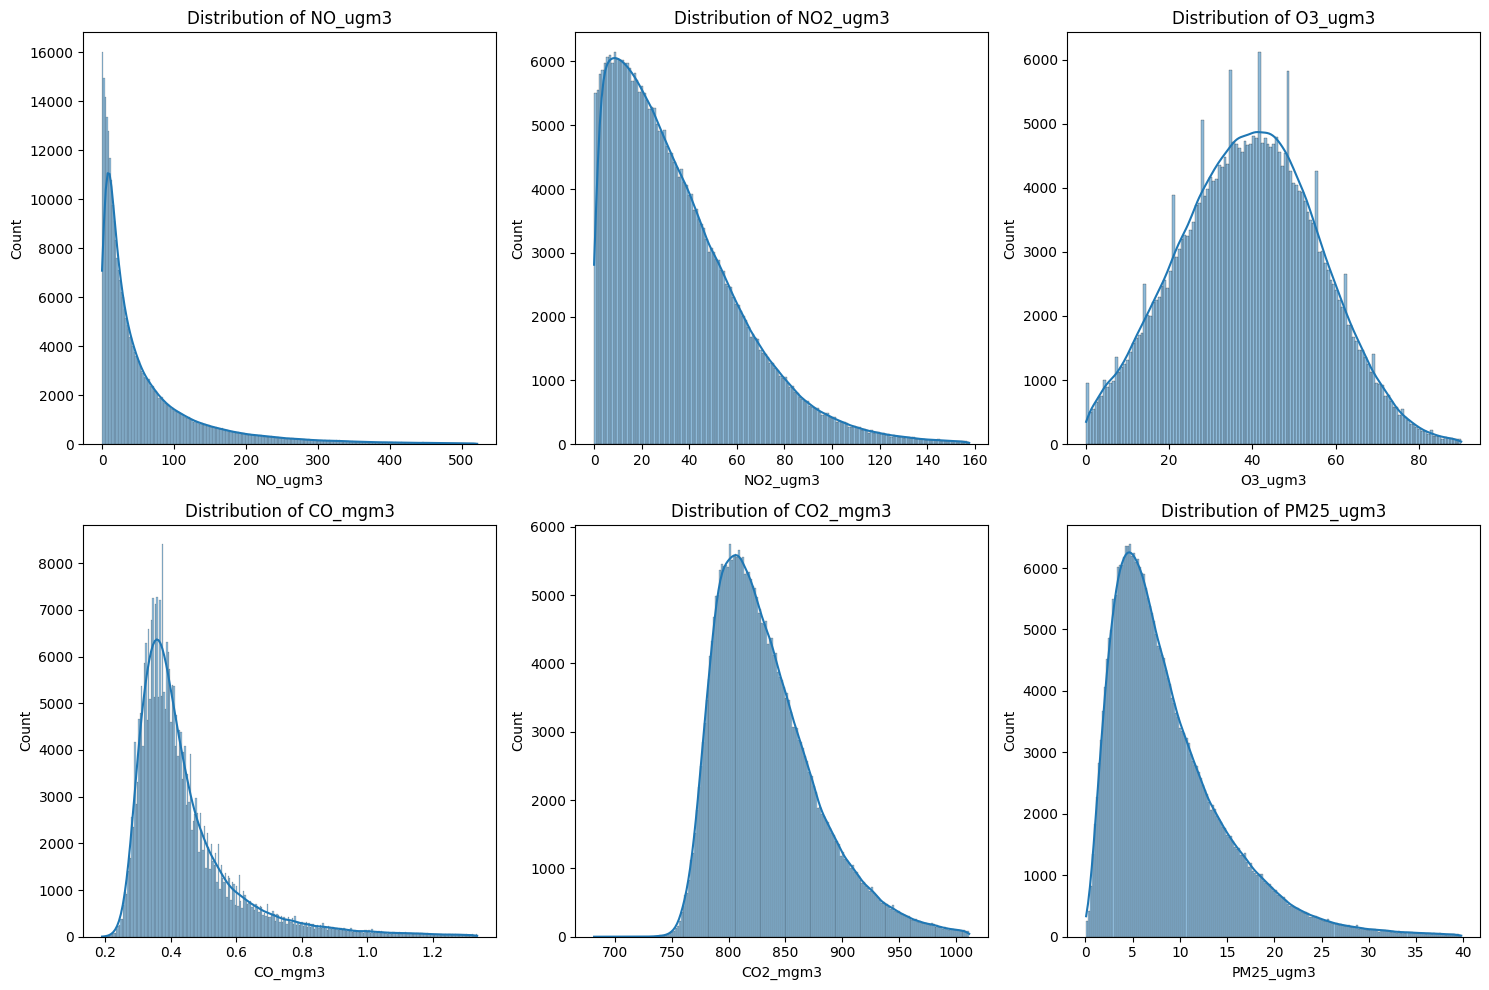

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


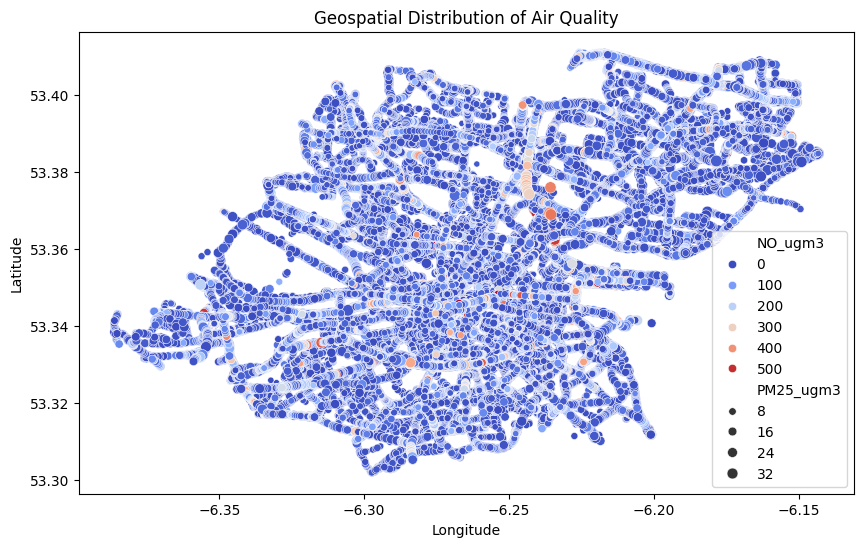

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('processed_AirView_DublinCity_Measurements_ugm3.csv')

# Display first rows and check the data info
print(df.head())
print(df.info())

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Summary statistics of the dataset
print(df.describe())

# Extract time-based features
df['gps_timestamp'] = pd.to_datetime(df['gps_timestamp'])
df['hour'] = df['gps_timestamp'].dt.hour
df['day_of_week'] = df['gps_timestamp'].dt.dayofweek
df['month'] = df['gps_timestamp'].dt.month

# Distribution of pollutants
pollutants = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']

plt.figure(figsize=(15, 10))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[pollutant], kde=True)
    plt.title(f'Distribution of {pollutant}')
    plt.xlabel(pollutant)
plt.tight_layout()
plt.show()

# Time-based trends for each pollutant
# plt.figure(figsize=(15, 8))
# for i, pollutant in enumerate(pollutants, 1):
#     plt.subplot(2, 3, i)
#     sns.boxplot(x='hour', y=pollutant, data=df)
#     plt.title(f'{pollutant} vs Hour of Day')
# plt.tight_layout()
# plt.show()

# Correlation heatmap
# corr_matrix = df[pollutants].corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Heatmap of Pollutants')
# plt.show()

# Geospatial distribution of pollutants
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', data=df, hue='NO_ugm3', palette='coolwarm', size='PM25_ugm3')
plt.title('Geospatial Distribution of Air Quality')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Time series for a specific pollutant (e.g., NO_ugm3)
# plt.figure(figsize=(12, 6))
# plt.plot(df['gps_timestamp'], df['NO_ugm3'], label='NO_ugm3')
# plt.title('NO_ugm3 Over Time')
# plt.xlabel('Time')
# plt.ylabel('NO_ugm3')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()



q2.6 train regression model

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load pre-split datasets
train_df = pd.read_csv('train_dataset.csv')
val_df = pd.read_csv('val_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

# Separate features and target
features = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3']  # Define feature columns
target = 'PM25_ugm3'  # target column

X_train = train_df[features]
y_train = train_df[target]

X_val = val_df[features]
y_val = val_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Print dataset shapes for verification
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Model training
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Predictions and evaluation
y_val_pred = model.predict(X_val)
# Correctly print predicted PM2.5 values

print("Validation MSE:", mean_squared_error(y_val, y_val_pred))

#testing
y_test_pred = model.predict(X_test)
print("Test MSE:", mean_squared_error(y_test,y_test_pred))


Training set shape: (220635, 5) (220635,)
Validation set shape: (47279, 5) (47279,)
Test set shape: (47280, 5) (47280,)
Validation MSE: 57.23767437396705
Test MSE: 43.852574619875384


q2.6 Train regression model(Modified) - data pre-processing

In [ ]:
import pandas as pd
import numpy as np
# Example dataset
data = pd.read_csv('processed_AirView_DublinCity_Measurements_ugm3.csv')

# Convert to DataFrame
df = pd.DataFrame(data)

# Convert gps_timestamp to pandas datetime (removing UTC for simplicity)
df['gps_timestamp'] = pd.to_datetime(df['gps_timestamp'].str.replace("UTC", ""))

# Extract time-based features
df['hour'] = df['gps_timestamp'].dt.hour          # Hour of the day
df['minute'] = df['gps_timestamp'].dt.minute      # Minute of the hour
df['day_of_week'] = df['gps_timestamp'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
df['day'] = df['gps_timestamp'].dt.day            # Day of the month
df['month'] = df['gps_timestamp'].dt.month        # Month
df['year'] = df['gps_timestamp'].dt.year          # Year

# Cyclical encoding for hour

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# save the file
df.to_csv('retime_processed_AirView_DublinCity_Measurements_ugm3.csv', index=False)


q2.6 train regression model(Modified) and testing

Validation MSE: 11.918062716860875
Validation R²: 0.6860769529500312
Test MSE: 12.089063552248202
Test R2: 0.6725446641774642


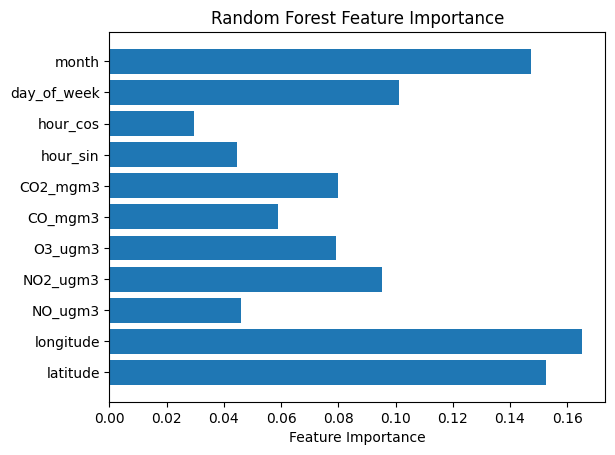

Predicted PM2.5 value: [5.8492965]


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv('retime_processed_AirView_DublinCity_Measurements_ugm3.csv')

# Feature engineering (selecting features and target)
features = ['latitude', 'longitude', 'NO_ugm3', 'NO2_ugm3', 'O3_ugm3',
            'CO_mgm3', 'CO2_mgm3', 'hour_sin', 'hour_cos', 'day_of_week', 'month']
target = 'PM25_ugm3'

X = df[features]
y = df[target]

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Validation predictions and evaluation
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("Validation MSE:", val_mse)
print("Validation R²:", val_r2)

# Test predictions and evaluation
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Test MSE:", test_mse)
print("Test R2:", test_r2)

# Feature importance
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

# Predict for new data
new_data = pd.DataFrame({
    'latitude': [53.3],
    'longitude': [-6.3],
    'NO_ugm3': [20],
    'NO2_ugm3': [30],
    'O3_ugm3': [40],
    'CO_mgm3': [0.3],
    'CO2_mgm3': [800],
    'hour_sin': [0.5],
    'hour_cos': [-0.5],
    'day_of_week': [2],
    'month': [5]
})
prediction = model.predict(new_data)
print("Predicted PM2.5 value:", prediction)


q2.7 traininaing classification model

In [3]:
# q2.7 train classification model
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load pre-split datasets
train_df = pd.read_csv('70classify_train_dataset.csv')
val_df = pd.read_csv('15classify_val_dataset.csv')
test_df = pd.read_csv('15classify_test_dataset.csv')

# Define features and target columns
features = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'PM25_ugm3']
target_column = 'Pollution_Level'  # Ensure this column exists in the datasets

# Separate features (X) and target (y) for each dataset
X_train = train_df[features]
y_train = train_df[target_column]

X_val = val_df[features]
y_val = val_df[target_column]

X_test = test_df[features]
y_test = test_df[target_column]

# Print dataset shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Initialize and train the K-Nearest Neighbors classifier
knn_model = KNeighborsClassifier(n_neighbors=5)  # Adjust n_neighbors as needed
knn_model.fit(X_train, y_train)

# Predict on validation and test sets
y_val_pred = knn_model.predict(X_val)
y_test_pred = knn_model.predict(X_test)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Validation Set):\n", classification_report(y_val, y_val_pred))
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_test_pred))


Training set shape: (220635, 5) (220635,)
Validation set shape: (47279, 5) (47279,)
Test set shape: (47280, 5) (47280,)
Validation Accuracy: 0.9626261130734576
Test Accuracy: 0.9682318104906937

Classification Report (Validation Set):
                                 precision    recall  f1-score   support

                          Good       0.97      0.99      0.98     32240
                      Moderate       0.95      0.92      0.94     14636
Unhealthy for Sensitive Groups       0.84      0.23      0.36       403

                      accuracy                           0.96     47279
                     macro avg       0.92      0.71      0.76     47279
                  weighted avg       0.96      0.96      0.96     47279


Classification Report (Test Set):
                                 precision    recall  f1-score   support

                          Good       0.97      0.99      0.98     33100
                      Moderate       0.97      0.92      0.95     14084
Unhe